## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)
import matplotlib.patches as patches

In [2]:
plt.style.use('bmh')

In [3]:
import spark_fof

In [4]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))

In [5]:
import spark_fof_c

## Set up data

In [6]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

In [7]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 1000000
ngs = 1
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
#centers = np.random.rand(ngs,3)*1.7 - 0.85
centers = np.array([0,0,0]).reshape(1,3)
for group, center in zip(range(ngs), centers): 
    print group, center
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.5,0,0],[0,.5,0],[0,0,.5]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

0 [0 0 0]


In [8]:
particles['pos'].shape

(1000000, 3)

In [9]:
import pynbody

In [10]:
s = pynbody.load('/cluster/home/roskarr/work/euclid256.nat')

/cluster/home/roskarr/miniconda2/lib/python2.7/site-packages/pynbody/snapshot/tipsy.py:130: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  "No readable param file in the run directory or parent directory: using defaults.", RuntimeWarning)


In [11]:
len(s)

16777216

In [12]:
particles = np.zeros(len(s), dtype=pdt)

In [13]:
particles['pos'] = s['pos']
particles['iOrder'] = range(len(s))

In [14]:
particles.nbytes

335544320

## Start Spark

In [15]:
import findspark
findspark.init()

In [16]:
import os
os.environ['SPARK_CONF_DIR'] = './conf'
os.environ['SPARK_DRIVER_MEMORY'] = '4G'

In [17]:
import pyspark
from pyspark import SparkContext, SparkConf

In [18]:
conf = SparkConf()

In [19]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '3G')
conf.set('spark.driver.memory', '4G')


In [20]:
sc = SparkContext(master='spark://e1104:7077', conf=conf, batchSize=0)

In [21]:
sc.addPyFile('spark_fof.py')
sc.addPyFile('spark_util.py')
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_fof_c.c')
sc.addPyFile('spark_fof_c.so')
sc.addPyFile('fof.so')

## Set up the domains

In [21]:
N = 3
tau = 7.8125e-4
mins = np.array([-.5,-.5,-.5], dtype=np.float)
maxs= np.array([.5,.5,.5], dtype=np.float)
domain_containers = spark_fof.setup_domain(N,tau,maxs,mins)

(-0.5, 0.5)

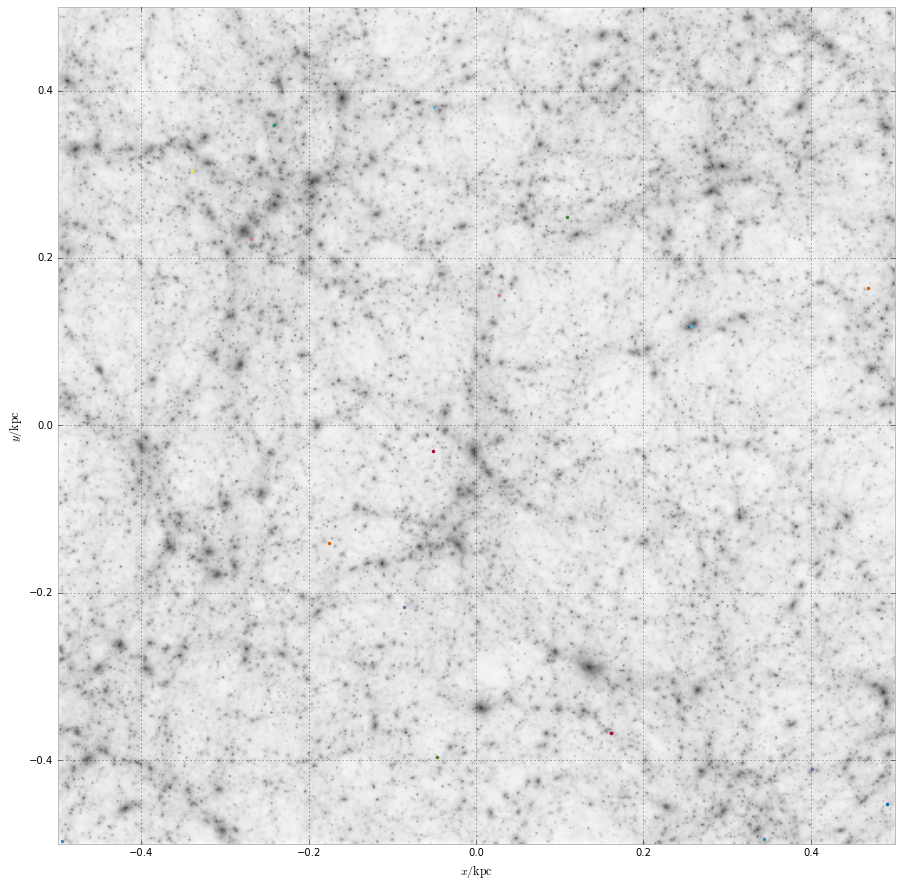

In [23]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
pynbody.plot.image(s.d, width=1, units = 'Msol Mpc^-2', cmap=plt.cm.Greys, show_cbar=False, subplot=ax)
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles[::1000000]: 
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'],2**N, np.array(mins), np.array(maxs))], ax=ax)
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'], 2**N, np.array(mins),np.array(maxs))].bufferRectangle, ax=ax)
    ax.plot(p['pos'][0], p['pos'][1], '.')
plt.draw()
ax.set_xlim(-.5,.5)
ax.set_ylim(-.5,.5)

### Make the base RDD

In [24]:
p_rdd = sc.parallelize(particles)

### Partition particles into domains and set the partition part of local group ID

In [25]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles_cython(particles, domain_containers, tau, mins, maxs))
                 .partitionBy(len(domain_containers))
                 .values())

### Run the local FOF

In [15]:
from spark_util import spark_cython

In [18]:
import fof

In [19]:
def run_local_fof(index, particle_iter, tau): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        fof.run(part_arr, tau)
    return part_arr

def encode_gid(pid, cid, bits=32):
    if bits == 32: 
        res = np.int64(int(np.binary_repr(pid,width=32)+np.binary_repr(cid,width=32),2))
    elif bits == 16:
        res = np.int32(int(np.binary_repr(pid,width=16)+np.binary_repr(cid,width=16),2))
    else: 
        raise RuntimeError('Group encoding must use either 16 or 32 bit integers')
    return res

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        #p = np.copy(part_arr[i])
        gid = part_arr['iGroup'][i]
        part_arr['iGroup'][i] = int(bin((partition_index<<16) | gid), 2)
    #    res = int(bin((partition_index<<16) | gid),2)
     #   part_arr['iGroup'][i] = res
    #    print res, partition_index, gid, spark_fof.encode_gid(partition_index, gid, 16)
   # print part_arr[:10]
    return part_arr

In [29]:
fof_rdd = part_rdd.mapPartitionsWithIndex(lambda index, particles: run_local_fof(index, particles, tau))\
                  .mapPartitionsWithIndex(set_group_id).cache()

### Group Merging stage

In [30]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd, [-.5,-.5,-.5], [.5,.5,.5])

In [31]:
%time fof_rdd.count()

CPU times: user 370 ms, sys: 10 ms, total: 380 ms
Wall time: 1min 39s


17053662

In [32]:
merged_rdd = fof_analyzer.merge_groups(0)

In [33]:
merged = merged_rdd.collect()

In [34]:
merged_arr = np.fromiter(merged, pdt)

In [35]:
groups = np.unique(merged_arr['iGroup'])

In [36]:
len(groups)

295534

In [ ]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
for group in groups: 
    inds = np.where(merged_arr['iGroup'] == group)[0]
    print group, len(inds)
    axs[0].plot(merged_arr['pos'][inds,1], merged_arr['pos'][inds,0], ',')
    axs[1].plot(merged_arr['pos'][inds,2], merged_arr['pos'][inds,0], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [ ]:
sc.show_profiles()

In [22]:
%time fof.run(particles, tau)

CPU times: user 21.4 s, sys: 20 ms, total: 21.4 s
Wall time: 21.4 s


105761